# **Loading dependecies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.dummy import DummyRegressor
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

# **Loading data**

In [3]:
!git clone git://gonito.net/mieszkania4

Cloning into 'mieszkania4'...
remote: Wymienianie obiektów: 4586, gotowe.
remote: Zliczanie obiektów: 100% (4586/4586), gotowe.
remote: Kompresowanie obiektów: 100% (4457/4457), gotowe.
remote: Razem 4586 (delty 1342), użyte ponownie 556 (delty 54), paczki użyte ponownie 0
Receiving objects: 100% (4586/4586), 13.25 MiB | 5.47 MiB/s, done.
Resolving deltas: 100% (1342/1342), done.


In [4]:
train = pd.read_csv("/content/mieszkania4/train/train.tsv",delimiter="\t")

In [5]:
dev = pd.read_csv("/content/mieszkania4/dev-0/in.tsv", delimiter="\t",header=None,names=train.columns[1:])
dev_expected = pd.read_csv("/content/mieszkania4/dev-0/expected.tsv",header=None)

# **Visualise some features**

In [6]:
train.describe()

,cena,Powierzchnia w m2,Liczba pokoi,Liczba pięter w budynku,Rok budowy,Powierzchnia działki w m2
count,4.938000e+03,4938.000000,4938.000000,4788.000000,1955.000000,526.000000
mean,4.198150e+05,76.422033,2.844674,5.315163,1984.839898,1260.515209
std,3.244901e+05,180.583310,1.247389,3.638266,34.007728,13082.350460
min,0.000000e+00,15.000000,1.000000,1.000000,1862.000000,20.000000
25%,2.824200e+05,45.000000,2.000000,3.000000,1970.000000,350.000000
50%,3.417040e+05,54.000000,3.000000,4.000000,2000.000000,500.000000
75%,4.500000e+05,72.000000,3.000000,5.000000,2010.000000,748.500000
max,1.000000e+07,11930.000000,8.000000,18.000000,2018.000000,300000.000000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4938 entries, 0 to 4937
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cena                       4938 non-null   int64  
 1   Powierzchnia w m2          4938 non-null   int64  
 2   Liczba pokoi               4938 non-null   int64  
 3   Miejsce parkingowe         4938 non-null   object 
 4   Liczba pięter w budynku    4788 non-null   float64
 5   Piętro                     4359 non-null   object 
 6   Typ zabudowy               3981 non-null   object 
 7   Okna                       3057 non-null   object 
 8   Materiał budynku           2067 non-null   object 
 9   Rok budowy                 1955 non-null   float64
 10  Forma własności            2090 non-null   object 
 11  Forma kuchni               1624 non-null   object 
 12  Stan                       1193 non-null   object 
 13  Stan instalacji            1030 non-null   objec

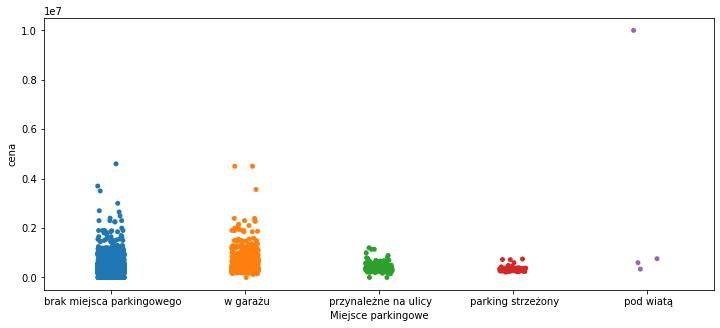

In [8]:
f,ax = plt.subplots(figsize=(12,5))
sns.stripplot(data=train, x = "Miejsce parkingowe", y = "cena")

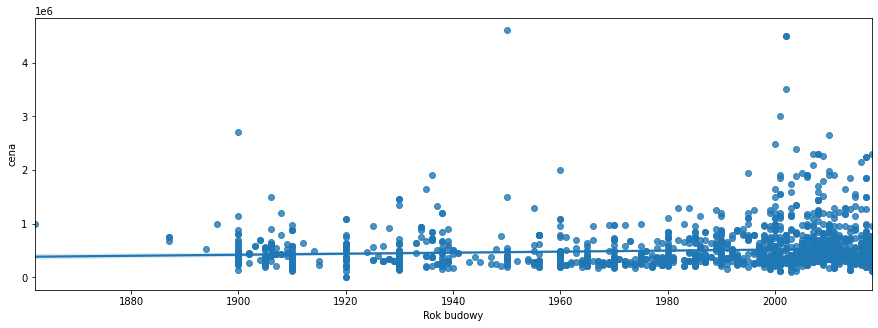

In [9]:
f,ax = plt.subplots(figsize=(15,5))
sns.regplot(data=train,x="Rok budowy", y="cena")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


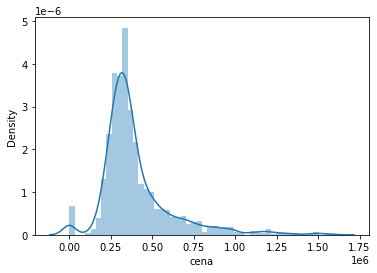

In [10]:
sns.distplot(train[train["cena"] < train["cena"].quantile(0.99)]["cena"])

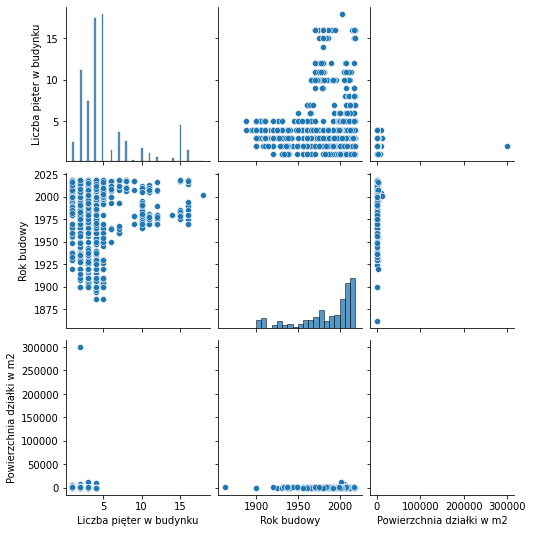

In [11]:
sns.pairplot(train.loc[:,train.dtypes == 'float64'])

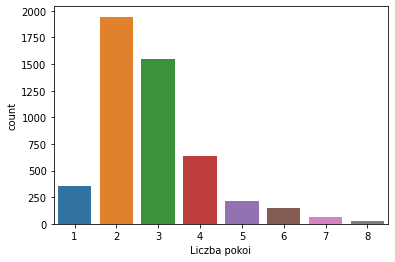

In [12]:
sns.countplot(x="Liczba pokoi",data=train)

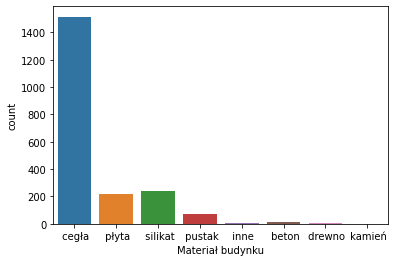

In [13]:
sns.countplot(x="Materiał budynku",data=train)

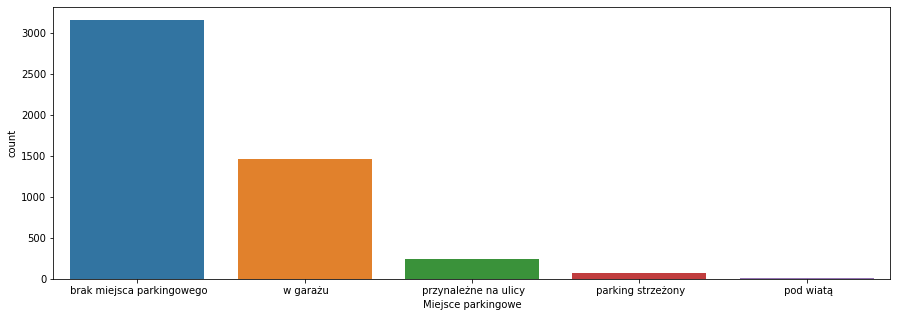

In [14]:
f, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="Miejsce parkingowe",data=train,ax=ax)

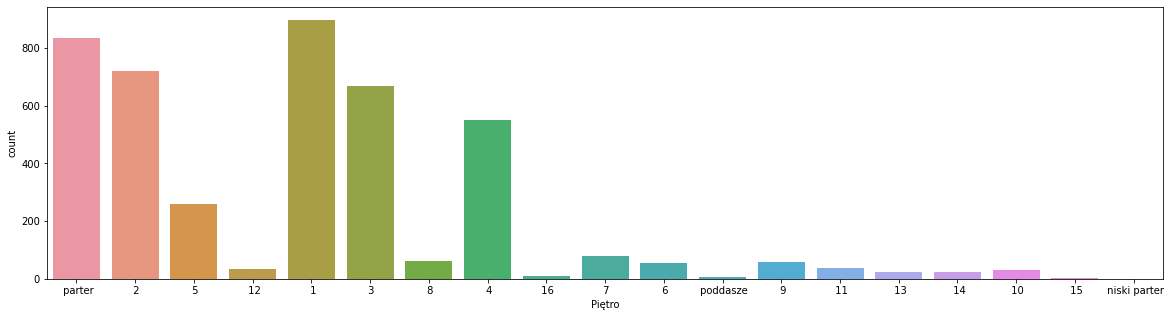

In [15]:
f, ax = plt.subplots(figsize=(20,5))
sns.countplot(x="Piętro",data=train,ax=ax)

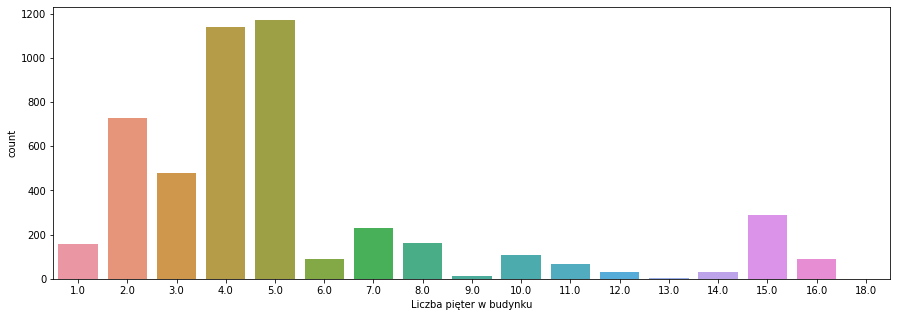

In [16]:
f, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="Liczba pięter w budynku",data=train,ax=ax)

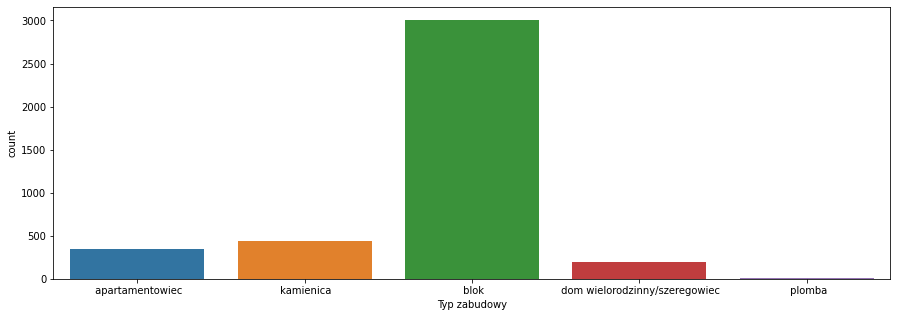

In [17]:
f, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="Typ zabudowy",data=train,ax=ax)

As you can see below we got some outliers. We should delete them.

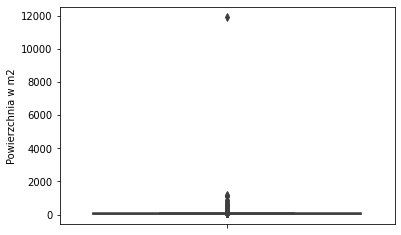

In [18]:
sns.boxplot(data=train, y = "Powierzchnia w m2")

**Choose and prepare features**


Features with **low amount of Nans** choosen

In [19]:
features_category = ["Liczba pokoi", "Miejsce parkingowe", "Typ zabudowy","Okna", "Piętro","old"]
features_value = ["Powierzchnia w m2","length","Liczba pięter w budynku"]

In [20]:
'''
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(np.array(train["Piętro"]).reshape(-1,1))
fm,ax=plt.subplots(figsize=(20,20))
sns.swarmplot(data=train,x="Piętro", y="cena",hue=labels,ax=ax,palette="colorblind")
'''

'\nfrom sklearn.cluster import KMeans\n\nkmeans = KMeans(n_clusters=3)\nlabels = kmeans.fit_predict(np.array(train["Piętro"]).reshape(-1,1))\nfm,ax=plt.subplots(figsize=(20,20))\nsns.swarmplot(data=train,x="Piętro", y="cena",hue=labels,ax=ax,palette="colorblind")\n'

Function for **preparing data**, all lines described below. We make function cause we need to use same operations for test / dev sets.

In [23]:
def prepare_data(data):
  #Add new column length of describtion
  data["length"] = data["opis"].apply(lambda desc: len(str(desc)))

  #Add column old or not
  data["old"] = data["Rok budowy"].apply(lambda year: 1 if year >= 1990 else 0)

  #Add column building plot or not
  data["field"] = data["Rok budowy"].apply(lambda year: 1 if year >= 1990 else 0)

  #Merge some columns
  data["Piętro"] = data["Piętro"].apply(lambda row:" 0" if (str(row) == " parter" or str(row) == " niski parter") else row)
  data["Piętro"] = data["Piętro"].apply(lambda row:" 1" if (str(row) == " poddasze") else row)
  data["Piętro"] = data["Piętro"].fillna(" 1")

  data["Miejsce parkingowe"] = data["Miejsce parkingowe"].apply(lambda row:" w garażu" if (str(row) == " pod wiatą") else row)

  #Set choosen category features as category type
  for col in features_category:
    data[col] = data[col].astype('category')
  
  #Fill number Nans with median
  data[features_value] = data[features_value].fillna(data[features_value].median())

  #Fill categorical Nans with most appearing
  data[features_category] = data[features_category].apply(lambda x:x.fillna(x.value_counts().index[0]))

  
  return data

In [24]:
train = prepare_data(train)

Lets delete some **outliers**

In [25]:
train = train[train["cena"] < train["cena"].quantile(0.99)]
train = train[train["cena"] > train["cena"].quantile(0.03)]

train = train[train["Powierzchnia w m2"] < 400]

**One hot Encoding**


In [26]:
X_train = pd.get_dummies(train[features_category])
X_train = pd.concat([train[features_value], X_train], axis=1, sort=False)

# First let's test on dummy regresor

In [27]:
dummy_regresor = DummyRegressor(strategy="median")
dummy_regresor.fit(X_train, train["cena"])

DummyRegressor(constant=None, quantile=None, strategy='median')

In [28]:
dev_input = prepare_data(dev)
dev_in = pd.get_dummies(dev_input[features_category])
dev_in = pd.concat([dev_input[features_value], dev_in], axis=1, sort=False)
dev_out = dummy_regresor.predict(dev_in)

In [29]:
mean_absolute_error(y_true= dev_expected,y_pred=dev_out)

176012.13524590165

# Now test other algorthims

Fix **missing columns** problem

In [30]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( dev_in.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    dev_in[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
dev_in = dev_in[X_train.columns]

**Create and fit model**

In [31]:
from sklearn import tree,ensemble
xgboost_model = xgb.XGBRegressor(random_state=2020,max_depth=10,n_estimators=1000)
#xgboost_model = tree.DecisionTreeRegressor()
xgboost_model.fit(X_train, train["cena"])

[18:40:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**Predict and evaluate**

In [32]:
xgb_out = xgboost_model.predict(dev_in)

In [33]:
mean_absolute_error(y_true= dev_expected,y_pred=xgb_out)

66206.29075947746

In [35]:
np.savetxt('/content/mieszkania4/dev-0/out.tsv', xgb_out, '%.0f')

In [37]:
!wget https://gonito.net/get/bin/geval
!chmod u+x geval

--2021-02-10 18:41:29--  https://gonito.net/get/bin/geval
Resolving gonito.net (gonito.net)... 178.216.200.70
Connecting to gonito.net (gonito.net)|178.216.200.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12638056 (12M) [application/octet-stream]
Saving to: ‘geval’

geval               100%[===================>]  12.05M  8.65MB/s    in 1.4s    

2021-02-10 18:41:31 (8.65 MB/s) - ‘geval’ saved [12638056/12638056]



In [45]:
!./geval -t "/content/mieszkania4/dev-0" --metric RMSE

198275.29420315672
